J'essaie de scraper des infos sur la page de présentation Fragantica de Black Phantom : https://www.fragrantica.com/perfume/By-Kilian/Black-Phantom-43632.html

Je veux scraper ces infos :
Nom du Parfum
Nom de la marque
Launch year
Perfume rating
Nombre de votant sur le Perfume rating
Saisonnalité (Hiver, automne… peut etre gardé juste la + votée)
Parfumeur
Main accord
‘Perfume Pyramide’  = [‘Top note’ , ‘Middle note’, Base note’]
Genre (en prenant celui qui à le plus de vote)
Longevite, Sillage (en prenant les votes)


## Imports

In [1]:
import requests
from bs4 import BeautifulSoup
import re

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager

import cloudscraper


## Les fonctions

In [ ]:
#Récupère le HTML de la page correspondant à l'URL donnée.
def get_html_non_headless(url):
    """
    Ouvre Chrome en mode normal (non-headless), va sur l'URL, 
    attend 1 seconde, récupère le HTML et ferme le navigateur.
    """
    # 1) Configuration basique du driver, sans headless
    options = webdriver.ChromeOptions()
    # Pas d'options.add_argument('--headless'), car on veut voir la fenêtre

    # 2) Création du driver
    driver = webdriver.Chrome(
        service=Service(ChromeDriverManager().install()),
        options=options
    )
    
    # 3) Accès à la page
    driver.get(url)
    
    # 4) Patiente un peu pour laisser la page (et scripts éventuels) se charger
    time.sleep(1)
    
    # 5) Récupère le code HTML
    html_content = driver.page_source
    
    # 6) Ferme le navigateur
    driver.quit()

    return html_content

## Le script

### Obtenir le contenu html de la page d'Angel Share

In [11]:
url = "https://www.fragrantica.com/perfume/By-Kilian/Angels-Share-62615.html"
html_content = get_html_non_headless(url)
    
# Vous pouvez ensuite parser le HTML avec BeautifulSoup
soup = BeautifulSoup(html, 'html.parser')


### Obtenir les infos sur angels share
- nom_parfum
      - marque
      - launch_year
      - perfume_rating
      - nb_votes
      - saison_plus_votee
      - parfumeur
      - main_accord
      - perfume_pyramid (dict avec top/middle/base)
      - genre
      - longevite_votes
      - sillage_votes


In [ ]:
data = {}

# 1) Nom du parfum        
match = re.search(r'/perfume/[^/]+/([^/]+)-\d+\.html', html_content)
if match:
    perfume_name = match.group(1)
    perfume_name = perfume_name.replace('-', ' ')
    data['nom_parfum'] = perfume_name
else:
    data['nom_parfum'] = None

#2) Marque
match = re.search(r'/perfume/([^/]+)/', html_content)
if match:
    brand_name = match.group(1)
    brand_name = brand_name.replace('-', ' ')
    data['marque'] = brand_name
else:
    data['marque'] = None

#3) Parfumeur
data['nose'] = None
nose_el = soup.select_one('div.cell a[href^="/noses/"]')
if nose_el:
    data['nose'] = nose_el.get_text(strip=True)

#4) Année de sortie
data['launch_year'] = None
title_el = soup.find('title')
if title_el:
    possible_year = title_el.get_text(strip=True)[-4:] #Les 4 derniers caractères du titre
    if possible_year.isdigit():
        data['launch_year'] = possible_year

#5) Perfume rating (note)
## ATTENTION, valeur en string, pas en float
data['rating_value'] = None
rating_el = soup.select_one('span[itemprop="ratingValue"]').get_text(strip=True)
if rating_el:
    data['rating_value'] = rating_el  

#6) Nb de votes
data['rating_count'] = None
rating_count_el = soup.select_one('span[itemprop="ratingCount"]').get_text(strip=True)
if rating_count_el:
    data['rating_count'] = rating_count_el


#7)Main accord
data['main_accords'] = []
main_accords_el = soup.find_all('div', class_= 'cell accord-box')
for element in main_accords_el:
    accord = element.get_text(strip=True)
    if accord:
        data['main_accords'].append(accord)


print(data)


{'nom_parfum': 'Angels Share', 'marque': 'By Kilian', 'nose': 'Benoist Lapouza', 'launch_year': '2020', 'rating_value': '4.38', 'rating_count': '15,696', 'main_accords': ['woody', 'warm spicy', 'sweet', 'vanilla', 'cinnamon', 'amber', 'powdery']}


In [ ]:
#Les listes des votes pour Longevity, Sillage, Gender, Price Feeling

#Sélecteur des blocs qui contiennent la catégorie + nombre de votes
tab_rows = soup.select('div.grid-x.grid-margin-x')  #On selectionne trop de chose donc on va devoir filtrer
tableau_votes = []
for row in tab_rows:
    # Récupérer le nom de la catégorie (ex: "female") dans <span class="vote-button-name">
    category_el = row.select_one('span.vote-button-name')
    # Récupérer le nombre de votes dans <span class="vote-button-legend">
    votes_el = row.select_one('span.vote-button-legend')
    if category_el and votes_el:
        category = category_el.get_text(strip=True)
        votes = votes_el.get_text(strip=True)   
        tableau_votes.append((category, votes))

for element in tableau_votes:
    if not element[1].isdigit(): #Si le nombre de votes n'est pas un nombre, et oui ça arrive !
        tableau_votes.remove(element)

# Définition des groupes
longevity_labels = {"very weak", "weak", "moderate", "long lasting", "eternal"}
sillage_labels = {"intimate", "moderate", "strong", "enormous"}
gender_labels = {"female", "more female", "unisex", "more male", "male"}
price_feeling_labels = {"way overpriced", "overpriced", "ok", "good value", "great value"}
# Séparation des données
longevity_list = [element for element in tableau_votes if element[0] in longevity_labels]
sillage_list = [element for element in tableau_votes if element[0] in sillage_labels]
gender_list = [element for element in tableau_votes if element[0] in  gender_labels]
price_feeling_list = [element for element in tableau_votes if element[0] in  price_feeling_labels]



[('very weak', '113'), ('weak', '341'), ('moderate', '2453'), ('long lasting', '4815'), ('eternal', '1395'), ('moderate', '4040')]
[('moderate', '2453'), ('intimate', '418'), ('moderate', '4040'), ('strong', '3600'), ('enormous', '798')]


<bound method PageElement.get_text of '\n'> 

<bound method PageElement.get_text of > 

<bound method PageElement.get_text of '\n'> 


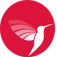

AttributeError: 'NoneType' object has no attribute 'get_text'

In [100]:
#8) Pyramide olfactive
data['perfume_pyramid'] = []

pyramid_el = soup.select_one('div' ,class_='grid-x grid-padding-y', id_='pyramid')
for element in pyramid_el:
    print(element.get_text, "\n")
    #data['perfume_pyramid'].append(element.get_text(strip=True))

pyramid_section = soup.select_one("#pyramid")
for element in pyramid_section.select("div.cell"):
    category = element.select_one("div.cell.small-4").get_text(strip=True)
    notes = [note.get_text(strip=True) for note in element.select("div.cell.small-8 a")]
    print(category, notes)
    data['perfume_pyramid'].append((category, notes))